Imports

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import helpers.evaluate
from helpers.model_list import model_map
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

#Import models
models = {name: model_class() for name, model_class in model_map.items()}

Load in Data

In [6]:
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


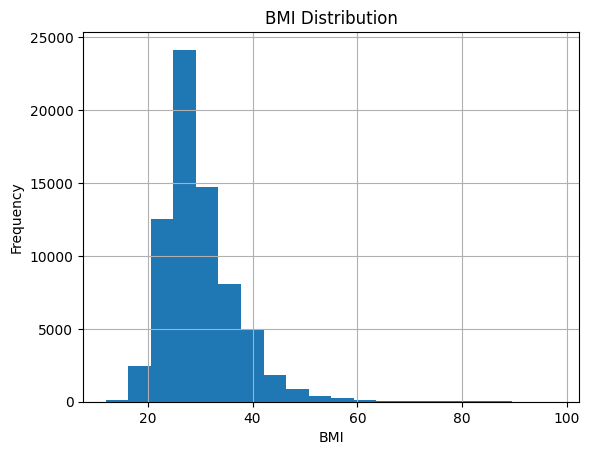

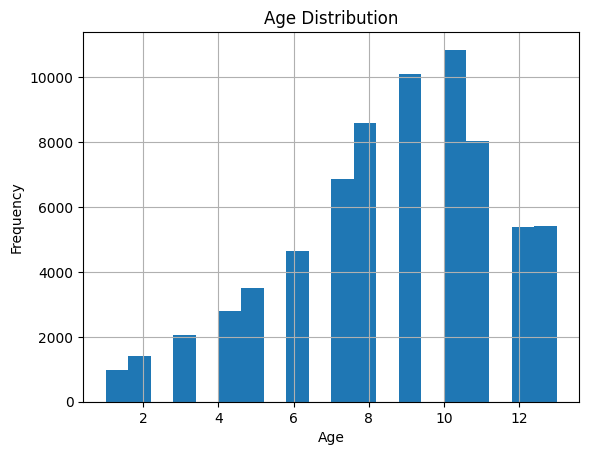

In [7]:
# Univariate Analysis
plt.figure()
df['BMI'].hist(bins=20)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.show()

plt.figure()
df['Age'].hist(bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


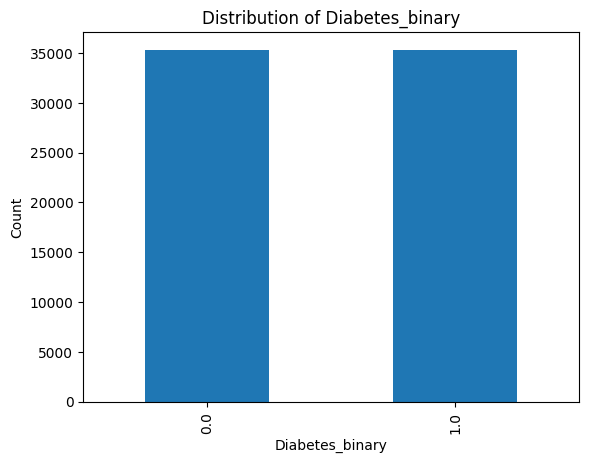

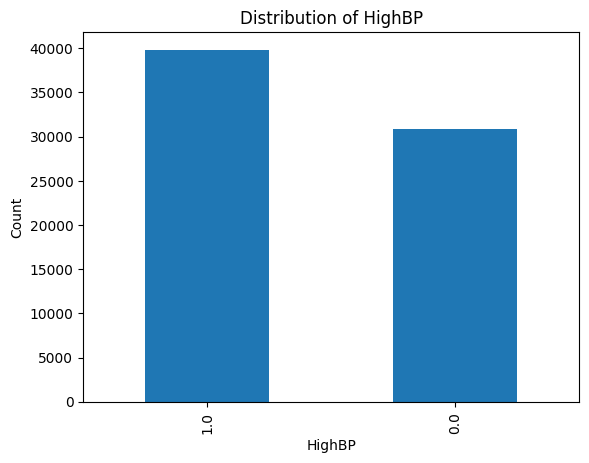

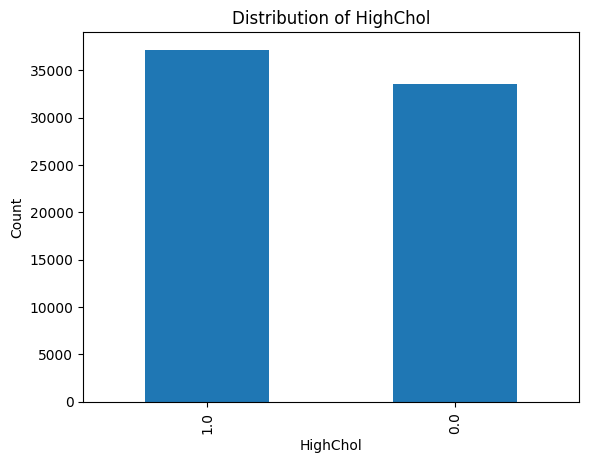

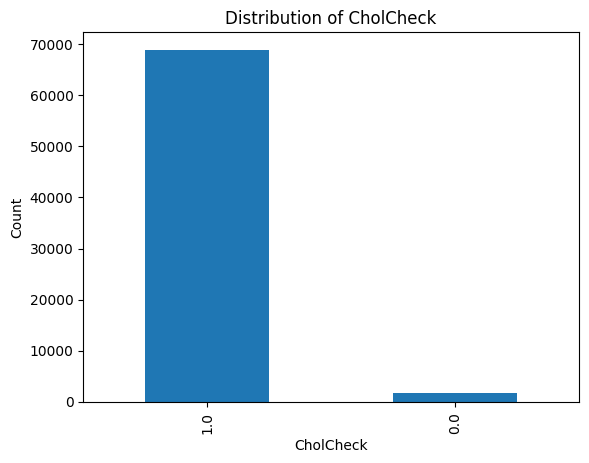

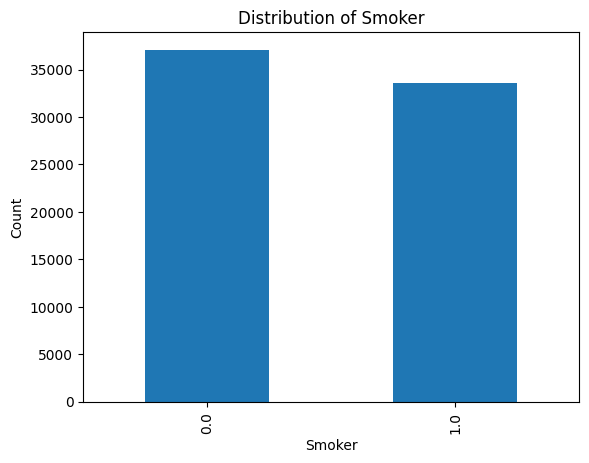

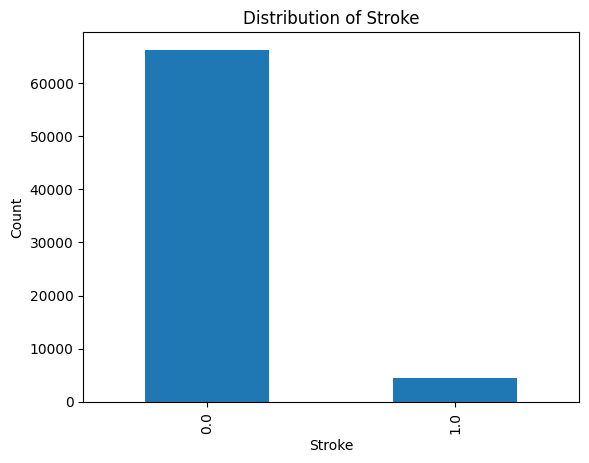

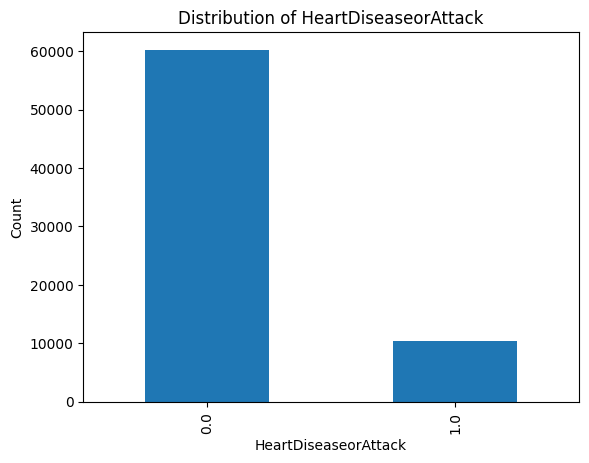

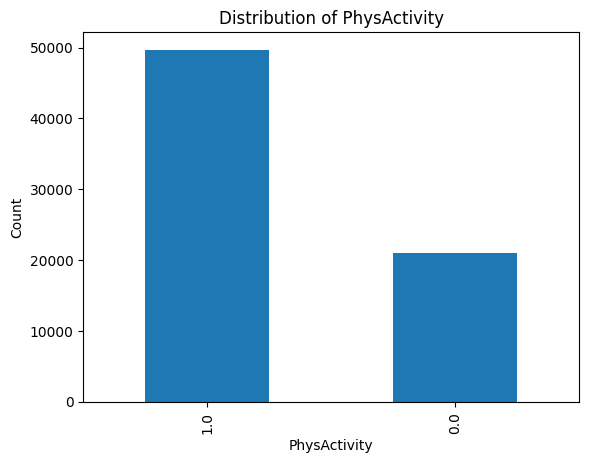

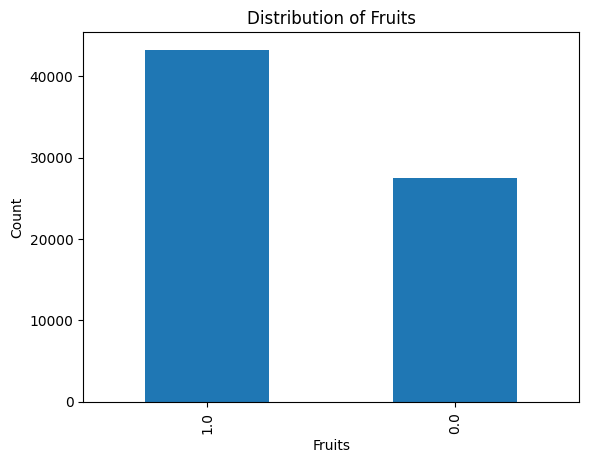

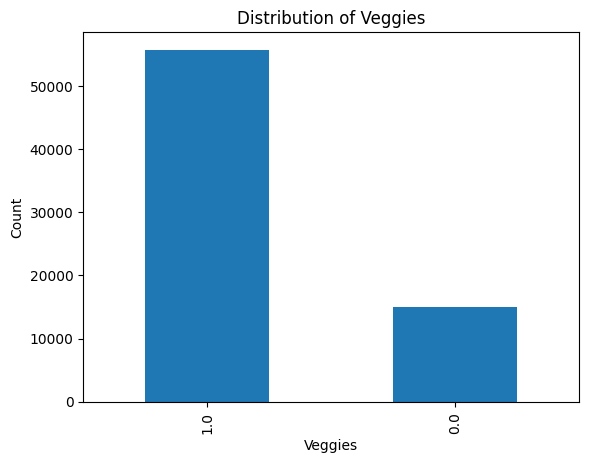

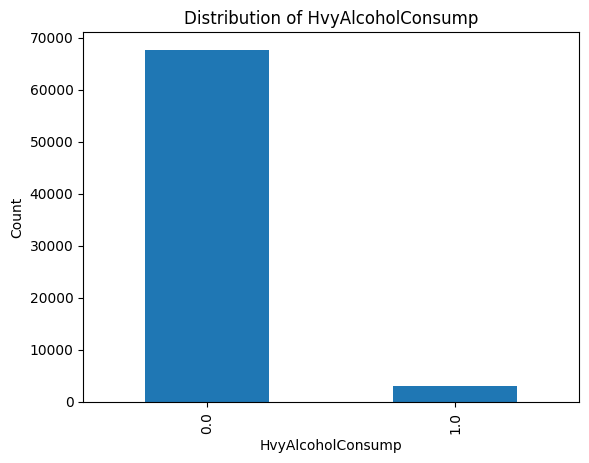

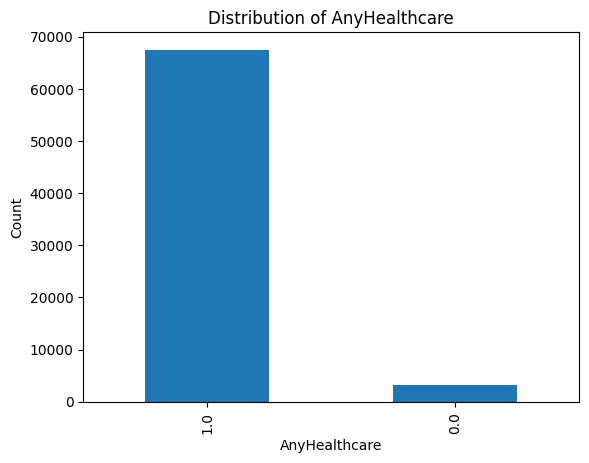

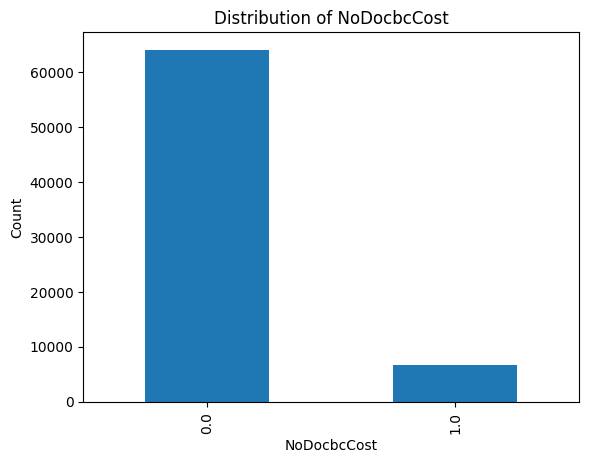

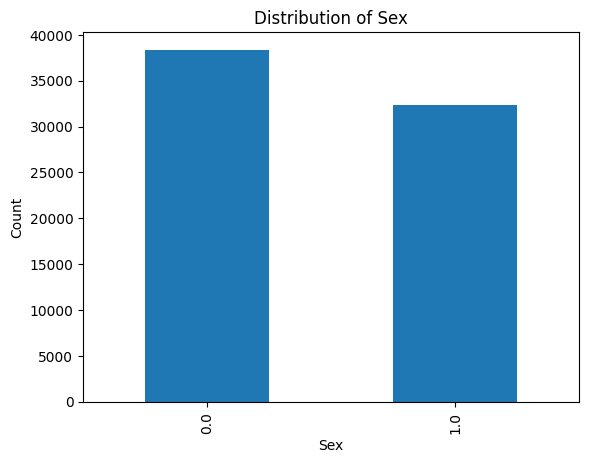

In [ ]:
# Identify categorical/binary features to visualize their distributions.

categorical_features = [
    'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck',
    'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'Sex'
]

for col in categorical_features:
    plt.figure()
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

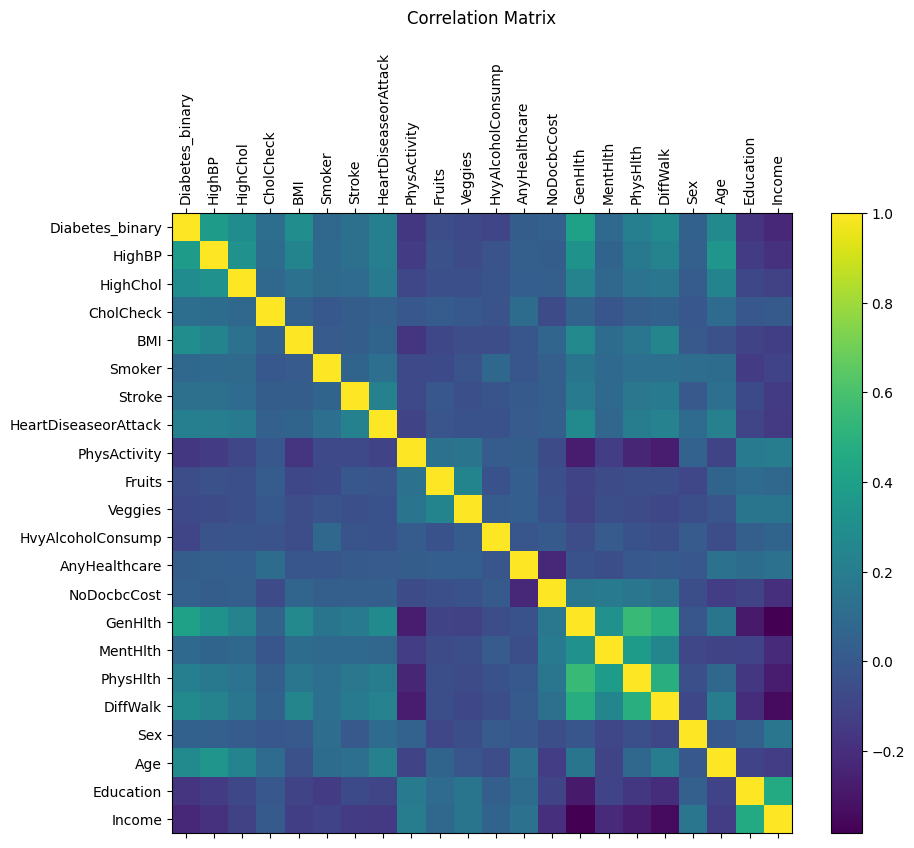

In [9]:
# Mulitvariate analysis

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=1)
plt.title("Correlation Matrix", pad=20)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.show()

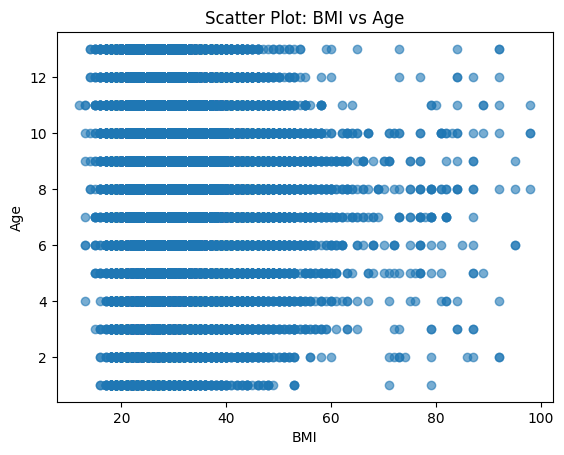

In [ ]:
# 2. Scatter Plot: BMI vs Age 
plt.figure()
plt.scatter(df['BMI'], df['Age'], alpha=0.6)
plt.title("Scatter Plot: BMI vs Age")
plt.xlabel("BMI")
plt.ylabel("Age")
plt.show()

Explore Data

In [3]:
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)


Dataset shape: (70692, 22)

Data types:
Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object


In [4]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
       Diabetes_binary        HighBP      HighChol     CholCheck  \
count     70692.000000  70692.000000  70692.000000  70692.000000   
mean          0.500000      0.563458      0.525703      0.975259   
std           0.500004      0.495960      0.499342      0.155336   
min           0.000000      0.000000      0.000000      0.000000   
25%           0.000000      0.000000      0.000000      1.000000   
50%           0.500000      1.000000      1.000000      1.000000   
75%           1.000000      1.000000      1.000000      1.000000   
max           1.000000      1.000000      1.000000      1.000000   

                BMI        Smoker        Stroke  HeartDiseaseorAttack  \
count  70692.000000  70692.000000  70692.000000          70692.000000   
mean      29.856985      0.475273      0.062171              0.147810   
std        7.113954      0.499392      0.241468              0.354914   
min       12.000000      0.000000      0.000000              0.000000   
2

In [5]:
# Count missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [6]:
# Check for duplicate records
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 1635


Clean Data

In [7]:
print("Dataset shape:", df.shape)
df = df.drop_duplicates()
print("New shape:", df.shape)

Dataset shape: (70692, 22)
New shape: (69057, 22)


Split Data

In [8]:
#Transform target
le = LabelEncoder()
y = le.fit_transform(y)

#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

#Scale Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Reassign col names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)


Train Models


--- Training and Evaluating Decision Tree ---
Decision Tree Performance:
Accuracy:  0.6527
Precision: 0.6528
Recall:    0.6527
F1 Score:  0.6526
Confusion Matrix:
[[18743  9506]
 [10137 18168]]


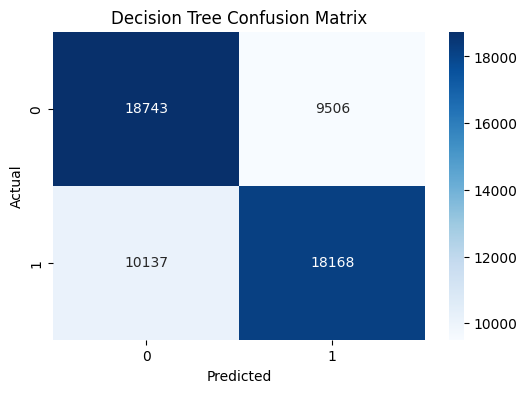


--- Training and Evaluating Logistic Regression ---
Logistic Regression Performance:
Accuracy:  0.7468
Precision: 0.7471
Recall:    0.7468
F1 Score:  0.7467
Confusion Matrix:
[[20550  7699]
 [ 6623 21682]]


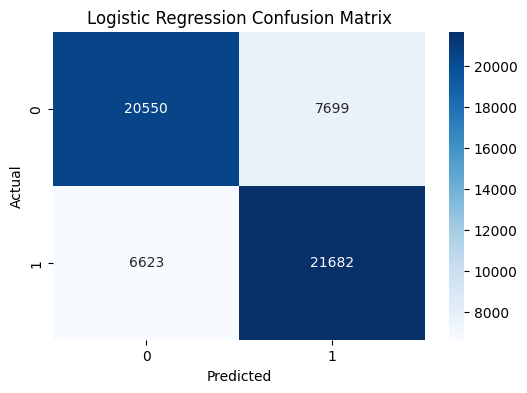


--- Training and Evaluating K Nearest Neighbors ---
K Nearest Neighbors Performance:
Accuracy:  0.6950
Precision: 0.6955
Recall:    0.6950
F1 Score:  0.6948
Confusion Matrix:
[[18913  9336]
 [ 7914 20391]]


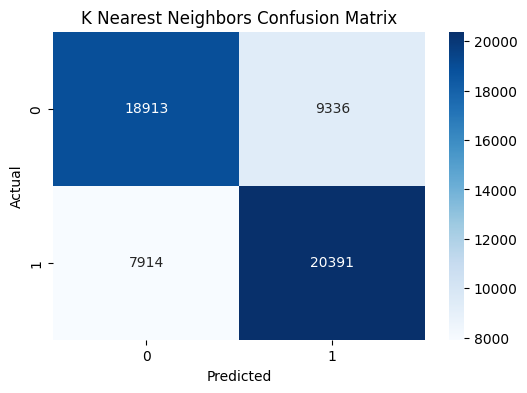


--- Training and Evaluating SVC ---
SVC Performance:
Accuracy:  0.7460
Precision: 0.7485
Recall:    0.7460
F1 Score:  0.7453
Confusion Matrix:
[[19620  8629]
 [ 5738 22567]]


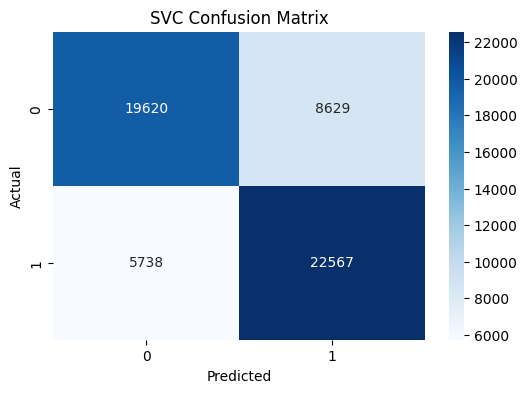

In [9]:


total_metrics = {}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")
    model.train(X_train_scaled, y_train)
    
    predictions = model.predict(X_test_scaled)
    
    metrics = helpers.evaluate.evaluate_model(y_test, predictions, name)
    total_metrics[name] = metrics


Report Stats

In [10]:
# Get best metrics
bestModel = ""
bestPerformance = 0.0
for name, metrics in total_metrics.items():
    if metrics["Accuracy"] > bestPerformance:
        bestModel = name
        bestPerformance = metrics["Accuracy"]

print("Best Model =", bestModel)
print("Model Accuracy =", bestPerformance)


Best Model = Logistic Regression
Model Accuracy = 0.746755313505676


Hyperparameter Tuning

In [ ]:
svc = models["SVC"]
svc.tune_hyperParams(X_test_scaled, y_test)

[I 2025-04-15 09:14:39,732] A new study created in memory with name: SVC
[I 2025-04-15 09:16:49,487] Trial 0 finished with value: 0.6603600995283185 and parameters: {'svc_c': 55777795.932767935, 'svc_kernel': 'sigmoid'}. Best is trial 0 with value: 0.6603600995283185.
[I 2025-04-15 09:22:07,813] Trial 1 finished with value: 0.5004951026523558 and parameters: {'svc_c': 1.6619085484734527e-07, 'svc_kernel': 'rbf'}. Best is trial 0 with value: 0.6603600995283185.
